# Question - Answering with Retrieval

본 대회의 과제는 중앙정부 재정 정보에 대한 **검색 기능**을 개선하고 활용도를 높이는 질의응답 알고리즘을 개발하는 것입니다. <br>이를 통해 방대한 재정 데이터를 일반 국민과 전문가 모두가 쉽게 접근하고 활용할 수 있도록 하는 것이 목표입니다. <br><br>
베이스라인에서는 평가 데이터셋만을 활용하여 source pdf 마다 Vector DB를 구축한 뒤 langchain 라이브러리와 llama-2-ko-7b 모델을 사용하여 RAG 프로세스를 통해 추론하는 과정을 담고 있습니다. <br>( train_set을 활용한 훈련 과정은 포함하지 않으며, test_set  에 대한 추론만 진행합니다. )

# Download Library

In [25]:
# !pip install accelerate
# !pip install -i https://pypi.org/simple/ bitsandbytes
# !pip install transformers[torch] -U

# !pip install datasets
# !pip install langchain
# !pip install langchain_community
# !pip install PyMuPDF
# !pip install sentence-transformers
# !pip install faiss-gpu # conda install 해야함

# Import Library

In [18]:
import os
import unicodedata
import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


import torch
import pandas as pd
from tqdm import tqdm
import fitz  # PyMuPDF

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig
)
from accelerate import Accelerator

# Langchain 관련
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

device = torch.device('mps')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the f

In [19]:
def extract_metadata(doc, page_num):
    """페이지 메타데이터 추출"""
    metadata = doc.metadata
    modified_date = metadata.get('modDate', datetime.datetime.now().isoformat())
    author = metadata.get('author', 'Unknown Author')
    title = metadata.get('title', 'Untitled Document')
    keywords = metadata.get('keywords', '')

    metadata_info = f"Page: {page_num + 1}, " \
                    f"File Name: {title}, " \
                    f"Modified Date: {modified_date}, " \
                    f"Author: {author}, " \
                    f"Keywords: {keywords}"
    return metadata_info

In [23]:
def print_embeddings(embeddings, num_samples=5):
    """임베딩 벡터의 일부를 출력"""
    for i, embedding in enumerate(embeddings[:num_samples]):
        print(f"Embedding {i + 1}: {embedding[:10]}...")  # 벡터의 처음 10개 요소만 출력

def visualize_embeddings(embeddings, num_samples=100):
    """임베딩 벡터를 2D로 시각화"""
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings[:num_samples])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
    plt.title("2D PCA of Embeddings")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Vector DB

In [26]:
def process_pdf(file_path, chunk_size=1000, chunk_overlap=500):
    """PDF 텍스트 추출 후 chunk 단위로 나누기"""
    # PDF 파일 열기
    doc = fitz.open(file_path)
    chunks = []
    
    # 모든 페이지의 텍스트 추출
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text = page.get_text()
        metadata_info = extract_metadata(doc, page_num)
        
        # 텍스트에 메타데이터 추가
        text_with_metadata = f"{metadata_info}\n{text}"
        
        # 텍스트를 chunk로 분할
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap
        )
        chunk_temp = splitter.split_text(text_with_metadata)
        logging.info(f"Total chunks created: {len(chunk_temp)}")
        
        # Document 객체 리스트 생성
        for t in chunk_temp:
            chunks.append(Document(page_content=t))
            
    return chunks


def create_vector_db(chunks, model_path="intfloat/multilingual-e5-small"):
    """FAISS DB 생성"""
    # 임베딩 모델 설정
    model_kwargs = {'device': device}
    encode_kwargs = {'normalize_embeddings': True}
    embeddings = HuggingFaceEmbeddings(
        model_name=model_path,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )
    # FAISS DB 생성 및 반환
    db = FAISS.from_documents(chunks, embedding=embeddings)

    # 임베딩 벡터 추출
    embedding_vectors = [embeddings.embed_query(chunk.page_content) for chunk in chunks]

    # 임베딩 벡터 확인
    print_embeddings(embedding_vectors)
    # visualize_embeddings(embedding_vectors)
    return db

def normalize_path(path):
    """경로 유니코드 정규화"""
    return unicodedata.normalize('NFC', path)


def process_pdfs_from_dataframe(df, base_directory):
    """딕셔너리에 pdf명을 키로해서 DB, retriever 저장"""
    pdf_databases = {}
    unique_paths = df['Source_path'].unique()
    
    for path in tqdm(unique_paths, desc="Processing PDFs"):
        # 경로 정규화 및 절대 경로 생성
        normalized_path = normalize_path(path)
        full_path = os.path.normpath(os.path.join(base_directory, normalized_path.lstrip('./'))) if not os.path.isabs(normalized_path) else normalized_path
        
        pdf_title = os.path.splitext(os.path.basename(full_path))[0]
        print(f"Processing {pdf_title}...")
        
        # PDF 처리 및 벡터 DB 생성
        chunks = process_pdf(full_path)
        db = create_vector_db(chunks)
        
        # Retriever 생성
        retriever = db.as_retriever(search_type="mmr", 
                                    search_kwargs={'k': 3, 'fetch_k': 8})
        
        # 결과 저장
        pdf_databases[pdf_title] = {
                'db': db,
                'retriever': retriever
        }
    return pdf_databases


# DB 생성

Processing PDFs:   0%|          | 0/9 [00:00<?, ?it/s]

Processing 중소벤처기업부_혁신창업사업화자금(융자)...
Embedding 1: [0.015544522553682327, -0.044121671468019485, -0.029285188764333725, -0.03484783694148064, 0.0717659667134285, -0.00572676956653595, 0.049111507833004, 0.060188692063093185, 0.05321793258190155, 0.040766458958387375]...
Embedding 2: [0.02005857042968273, -0.014138450846076012, -0.008707377128303051, -0.03567655012011528, 0.10214143246412277, -0.013562668114900589, 0.044703785330057144, 0.05565892904996872, 0.07151733338832855, 0.036586396396160126]...
Embedding 3: [0.023627905175089836, -0.026761015877127647, -0.013579986989498138, -0.03632544353604317, 0.10493652522563934, 0.014932701364159584, 0.04964764788746834, 0.03884504362940788, 0.0810229703783989, 0.02867024391889572]...
Embedding 4: [0.007087278179824352, -0.05281616002321243, -0.030570046976208687, -0.01409395132213831, 0.10980162024497986, 0.004716554656624794, 0.03277693688869476, 0.05408017709851265, 0.09801580756902695, 0.05214767903089523]...


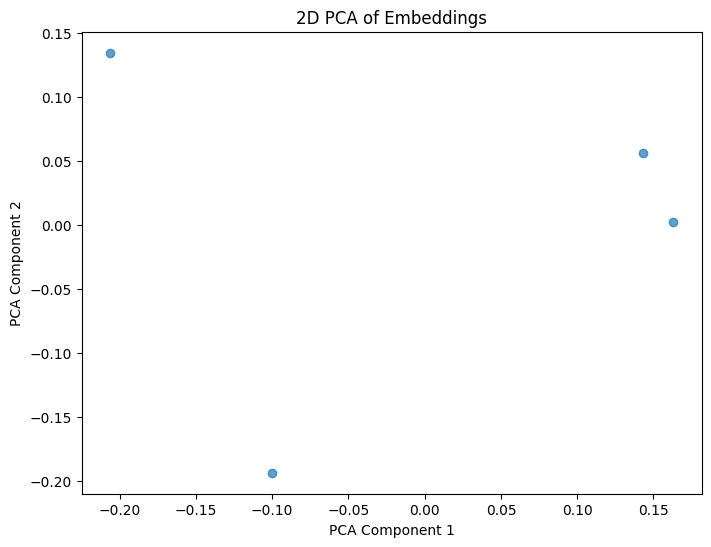

Processing PDFs:  11%|█         | 1/9 [00:06<00:54,  6.85s/it]

Processing 보건복지부_부모급여(영아수당) 지원...
Embedding 1: [0.011012719944119453, -0.02019263431429863, -0.023774100467562675, -0.04363209009170532, 0.10363456606864929, 0.0393381342291832, 0.049318525940179825, 0.08892946690320969, 0.06612643599510193, 0.03607357293367386]...
Embedding 2: [0.021014034748077393, -0.0044896239414811134, -0.0314989909529686, -0.039016153663396835, 0.0984095111489296, 0.028349800035357475, 0.030796198174357414, 0.10558464378118515, 0.07805736362934113, 0.03179970383644104]...
Embedding 3: [0.026122165843844414, -0.01856362447142601, -0.010228510946035385, -0.028835613280534744, 0.08937782049179077, 0.020344415679574013, 0.044879890978336334, 0.09533201903104782, 0.08925824612379074, 0.030466889962553978]...


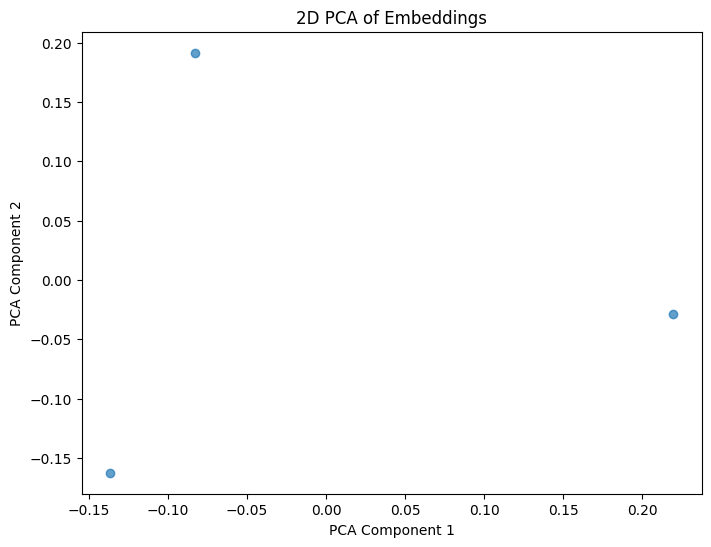

Processing PDFs:  22%|██▏       | 2/9 [00:11<00:37,  5.41s/it]

Processing 보건복지부_노인장기요양보험 사업운영...
Embedding 1: [0.024693896993994713, -0.01493590883910656, -0.03550102934241295, -0.08232057094573975, 0.10117094218730927, 0.005746094975620508, 0.04799874499440193, 0.06686422973871231, 0.05525163188576698, 0.03215882182121277]...
Embedding 2: [0.017938334494829178, -0.009041938930749893, -0.05483430624008179, -0.08806943893432617, 0.11015493422746658, -0.005663743242621422, 0.032114095985889435, 0.054100703448057175, 0.05872969701886177, 0.029778340831398964]...
Embedding 3: [0.04004831612110138, -0.023317594081163406, -0.06251112371683121, -0.09455059468746185, 0.1035955473780632, -0.017937522381544113, 0.01979629509150982, 0.031085092574357986, 0.07674210518598557, 0.04023102670907974]...
Embedding 4: [0.03291434049606323, 0.004817337263375521, -0.05688709765672684, -0.07656173408031464, 0.1144409105181694, 0.005045583005994558, 0.02242118865251541, 0.07008902728557587, 0.07060878723859787, 0.04388921335339546]...
Embedding 5: [0.028825441375374794

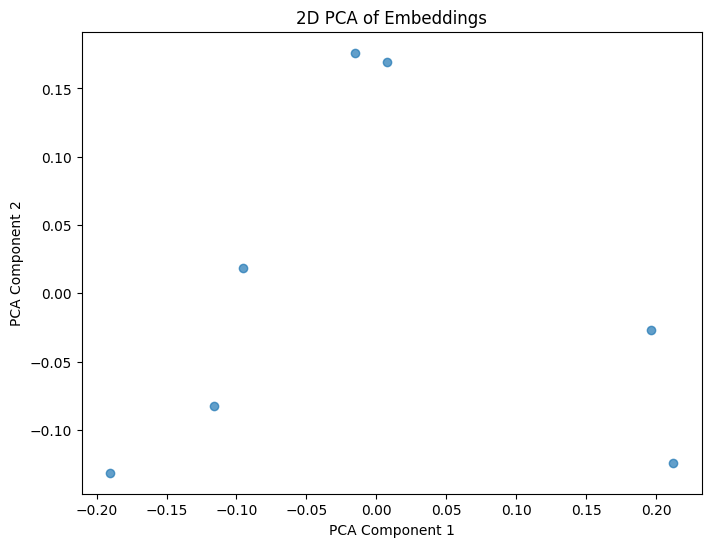

Processing PDFs:  33%|███▎      | 3/9 [00:15<00:30,  5.01s/it]

Processing 산업통상자원부_에너지바우처...
Embedding 1: [0.007896783761680126, -0.0014610138023272157, -0.025314170867204666, -0.07405702769756317, 0.05029698833823204, 0.02517390251159668, 0.0076795960776507854, 0.08343666791915894, 0.03522363305091858, 0.029099537059664726]...
Embedding 2: [0.018690219148993492, 0.013726800680160522, -0.01378483697772026, -0.03496750444173813, 0.059184640645980835, 0.043992433696985245, 0.02651524357497692, 0.10215428471565247, 0.05089137703180313, 0.028928078711032867]...
Embedding 3: [0.04019131511449814, 0.007632073946297169, -0.026896163821220398, -0.03545454517006874, 0.08402994275093079, 0.012532549910247326, 0.020935559645295143, 0.08267240971326828, 0.05908815562725067, 0.06836720556020737]...
Embedding 4: [0.04636552929878235, 0.0060422345995903015, -0.028869125992059708, -0.03773588314652443, 0.08218591660261154, 0.01364140585064888, 0.013907298445701599, 0.09303826838731766, 0.05984918773174286, 0.055212996900081635]...
Embedding 5: [0.03050218522548675

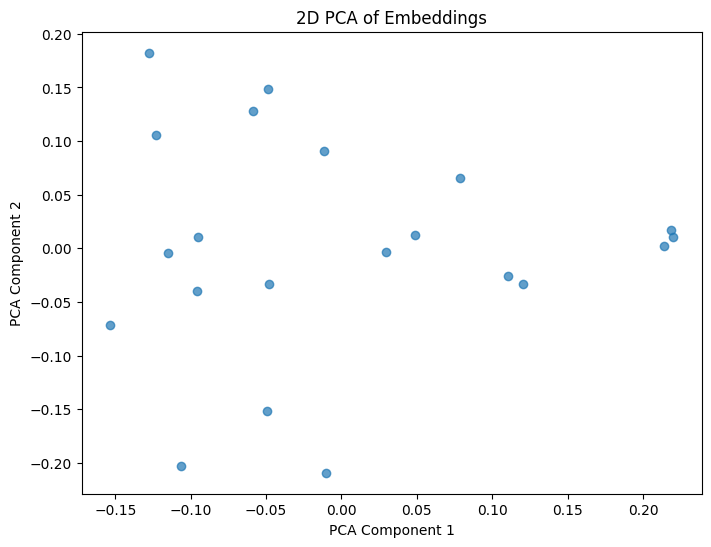

Processing PDFs:  44%|████▍     | 4/9 [00:20<00:25,  5.08s/it]

Processing 국토교통부_행복주택출자...
Embedding 1: [0.019273780286312103, -0.01577777974307537, -0.011556476354598999, -0.05571894720196724, 0.07773295789957047, 0.006757162045687437, 0.04861430823802948, 0.10116218030452728, 0.054618533700704575, 0.06425685435533524]...
Embedding 2: [0.036368973553180695, -0.0019016740843653679, 0.009321196936070919, -0.034240107983350754, 0.09528973698616028, 0.020329080522060394, 0.029032187536358833, 0.11322176456451416, 0.058702755719423294, 0.0612623505294323]...
Embedding 3: [0.059938788414001465, -0.00778333842754364, -0.0193775724619627, -0.05663202702999115, 0.08322441577911377, 0.0021235551685094833, 0.008043217472732067, 0.09909053146839142, 0.07740357518196106, 0.0678153857588768]...
Embedding 4: [0.05149592086672783, 0.004676324315369129, -0.04338178411126137, -0.034962598234415054, 0.09147437661886215, -0.0036969014909118414, 0.036950815469026566, 0.08123760670423508, 0.06748504191637039, 0.06801975518465042]...
Embedding 5: [0.03968280926346779, -

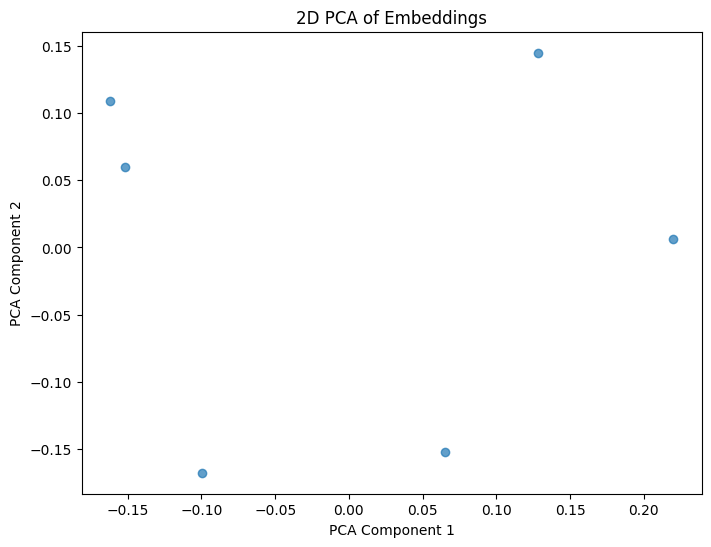

Processing PDFs:  56%|█████▌    | 5/9 [00:24<00:18,  4.65s/it]

Processing 「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》...


Processing PDFs:  56%|█████▌    | 5/9 [00:30<00:24,  6.19s/it]


KeyboardInterrupt: 

In [27]:
base_directory = './open' # Your Base Directory
df = pd.read_csv('./open/test.csv')
pdf_databases = process_pdfs_from_dataframe(df, base_directory)

# MODEL Import

In [12]:
def setup_llm_pipeline():
    # 4비트 양자화 설정
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    # 모델 ID 
    model_id = "beomi/llama-2-ko-7b"

    # 토크나이저 로드 및 설정
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.use_default_system_prompt = False

    # 모델 로드 및 양자화 설정 적용
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        # quantization_config=bnb_config, # 양자화 설정
        # 양자화 설정을 사용하지 않을 시, 발생하는 차이점
        # 1. 모델 메모리 사용량 증가, 2. 속도 감소, 3. 양자화는 일부 정밀도 희생 -> 미미하지만 정확도 증가
        device_map="auto",
        trust_remote_code=True )

    # HuggingFacePipeline 객체 생성
    text_generation_pipeline = pipeline(
        model=model,
        tokenizer=tokenizer,
        task="text-generation",
        temperature=0.2,
        return_full_text=False,
        max_new_tokens=128,
    )

    hf = HuggingFacePipeline(pipeline=text_generation_pipeline)

    return hf

In [13]:
# LLM 파이프라인
llm = setup_llm_pipeline()

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


# Langchain 을 이용한 추론

In [14]:
def normalize_string(s):
    """유니코드 정규화"""
    return unicodedata.normalize('NFC', s)

def format_docs(docs):
    """검색된 문서들을 하나의 문자열로 포맷팅"""
    context = ""
    for doc in docs:
        context += doc.page_content
        context += '\n'
    return context

# 결과를 저장할 리스트 초기화
results = []

# DataFrame의 각 행에 대해 처리
for _, row in tqdm(df.iterrows(), total=len(df), desc="Answering Questions"):
    # 소스 문자열 정규화
    source = normalize_string(row['Source'])
    question = row['Question']

    # 정규화된 키로 데이터베이스 검색
    normalized_keys = {normalize_string(k): v for k, v in pdf_databases.items()}
    retriever = normalized_keys[source]['retriever']

    # RAG 체인 구성
    template = """
    다음 정보를 바탕으로 질문에 답하세요:
    {context}

    질문: {question}

    답변:
    """
    prompt = PromptTemplate.from_template(template)

    # RAG 체인 정의
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    # 답변 추론
    print(f"Question: {question}")
    full_response = rag_chain.invoke(question)

    print(f"Answer: {full_response}\n")

    # 결과 저장
    results.append({
        "Source": row['Source'],
        "Source_path": row['Source_path'],
        "Question": question,
        "Answer": full_response
    })

Answering Questions:   0%|          | 0/98 [00:00<?, ?it/s]/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Question: 2022년 혁신창업사업화자금(융자)의 예산은 얼마인가요?


Answering Questions:   1%|          | 1/98 [01:55<3:07:27, 115.96s/it]

Answer: 2022년 혁신창업사업화자금(융자)의 예산은 2,300,00,00원입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 중소벤처기업부의 혁신창업사업화자금(융자) 사업목적은 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:   2%|▏         | 2/98 [02:22<1:41:32, 63.46s/it] 

Answer: 사업명: 혁신창업사업화자금(융자)​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 중소벤처기업부의 혁신창업사업화자금(융자) 사업근거는 어떤 법률에 근거하고 있나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:   3%|▎         | 3/98 [02:43<1:09:17, 43.77s/it]

Answer: 중소기업창업지원법 제35조​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 2010년에 신규 지원된 혁신창업사업화자금은 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:   4%|▍         | 4/98 [03:03<53:58, 34.45s/it]  

Answer: 2010년 1월 1일부터 2014년 12월 31일까지 4년간 지원된 사업입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 혁신창업사업화자금 중 2020년에 신규 지원된 자금은 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:   5%|▌         | 5/98 [03:23<45:41, 29.47s/it]

Answer: 2020년 혁신창업사업화자금 지원대상은 창업 7년 미만 기업으로, 2019년 12월 31일 이전 창업기업을 대상으로 지원합니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재창업자금이 재도약지원자금으로 이관된 연도는 언제인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:   6%|▌         | 6/98 [03:44<40:27, 26.38s/it]

Answer: 2014년 1월 1일부터 재창업자금을 재도약지원자금으로 이관하여 운영하고 있습니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 창업기반지원과 신청 대상이 중복인 자금이 어떤 것이며, 이 자금이 폐지된 연도는 언제인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:   7%|▋         | 7/98 [04:04<37:03, 24.43s/it]

Answer: 창업기반지원과 신청 대상이 중복인 자금은 창업기업지원자금(융자)입니다.​창업기업지원자금(융자)은 창업기업에 대한 융자지원을 통해 창업기업의 경영안정 및 경쟁력 강화를 도모하기 위한 자금입니다.​창업기업지원자금(융자)은 창업기업지원자금(융자)과 창업기업지원자금(융자)으로 구분되며, 창업기업지원자금(융자)은 창업기업지원자금(융자)과 창업기업지원자금(융자)으로 구분됩니다.​창업기업지원자금(융자)은 창업기업지원

Question: 혁신창업사업화자금(융자) 사업을 시행하는 주체는 누구인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:   8%|▊         | 8/98 [04:24<34:39, 23.11s/it]

Answer: 사업의 총괄·조정·집행·평가·성과관리를 수행하는 기관은 중소벤처기업진흥공단입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 혁신창업사업화자금(융자) 사업 집행절차는 어떻게 되나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:   9%|▉         | 9/98 [04:45<32:59, 22.25s/it]

Answer: 사업계획수립/공고​(중기부, 중진공)​⇨사전상담 및 신청·접수​(중소기업 →중진공)​⇨서류 및 현장실사​(중진공 →중소기업)​⇩​융자 실행​(중진공, 은행 →중소기업)​⇦​지원결정통보​(중진공 →중소기업)​⇦​평가 및 승인​(중진공 →중소기업)​- 2006. 1​지원대상을 업력 5

Question: 부모급여 지원 사업의 목적은 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  10%|█         | 10/98 [05:08<32:52, 22.41s/it]

Answer: 부모급여 지원 사업은 출산 및 양육으로 손실되는 소득을 보전하고, 주 양육자의 직접돌봄이 중요하므로 영아기 돌봄을 두텁게 지원하기 위해 부모급여 지급을 확대하는 사업입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 부모급여(영아수당)의 2024년 확정된 예산은 몇백만원인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  11%|█         | 11/98 [05:27<31:11, 21.51s/it]

Answer: 2024년 예산은 5,658,766건 지원 예정(월평균 472천명)입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 부모급여 지원 사업은 어떤 법령상 근거를 갖고 추진되고 있나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  12%|█▏        | 12/98 [05:46<29:52, 20.84s/it]

Answer: 아동수당법 제4조제5항에 근거하여 추진되고 있습니다.​​2. 추진경위​- 2018년 9월 14일 아동수당법 시행​- 2019년 1월 1일 아동수당법 시행령 시행​- 2019년 1월 1일 아동수당법 시행령 시행령 시행​- 2019년 1월 1일 아동수당법 시행령 시행령 시행​- 2019년 1월 1일 아동수당법 시행령 시행령 시행

Question: 영아수당 도입에 대한 추진경위는 어떻게 되나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  13%|█▎        | 13/98 [06:06<29:14, 20.65s/it]

Answer: 영아수당 도입은 저출산‧고령사회위원회에서 2018년 12월 20일 영아수당 도입을 결정하였습니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 부모급여 지원사업은 언제부터 시행되었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  14%|█▍        | 14/98 [06:27<28:48, 20.58s/it]

Answer: 부모급여 지원사업은 2022년 1월 1일부터 시행됩니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 보건복지부의 부모급여(영아수당) 지원 사업시행방법은 무엇이며, 사업 수혜자는 누구인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  15%|█▌        | 15/98 [06:47<28:23, 20.53s/it]

Answer: 1. 사업시행방법​- 사업시행방법 : 지자체 보조​- 사업시행주체 : 보건복지부, 시‧도 및 시‧군‧구​- 사업 수혜자 : 만 0~1세 아동​- 사업 수혜자 : 만 0~1세 아동​- 보조, 융자, 출연, 출자 등의 경우 보조.융자 등 지원 비율 및 법적근거​내역사업명​구분​피보조.​피출연 등​기관명​지원 금액​(2024예산)​지원

Question: 노인장기요양보험 사업 운영에 대한 목적은 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  16%|█▋        | 16/98 [07:16<31:25, 22.99s/it]

Answer: 노인장기요양보험 사업은 고령이나 노인성 질병으로 일상생활을 혼자서 수행하기​어려운 노인 등에게 신체 또는 가사 활동 등을 제공하는 노인장기요양보험에 국고지원을​하여, 효율적인 정책추진으로 노후의 건강증진 및 생활 안정을 도모하고 가족의 부담을​완화하여 국민 삶의 질을 향상시키기 위한 것입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 노인장기요양보험 운영지원에 대한 사업 내용을 설명해줘.


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  17%|█▋        | 17/98 [07:38<30:32, 22.63s/it]

Answer: 1. 사업 코드 정보​구분​회계​소관​실국(기관)​계정​분야​부문​코드​11​일반회계​23​보건복지부​인구정책실​노인정책관​080​08B​명칭​사회복지​노인​구분​프로그램​단위사업​세부사업​코드​2200​2231​303​명칭​노인의료보장​노인장기요양보험 지원​노인장기요양보험 사업운영​2. 사업 지원 형태 및 지원

Question: 국고지원을 받는 기타 의료급여수급권자는 누구인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  18%|█▊        | 18/98 [07:58<29:11, 21.89s/it]

Answer: - (기타 의료급여수급권자 급여비용 국가부담금) 「국민기초생활 보장법」에 의한 의료​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 장기요양보험가입자 및 피부양자의 자격취득과 관련하여 어떤 법률을 준용해야 하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  19%|█▉        | 19/98 [08:18<28:11, 21.41s/it]

Answer: 1. 장기요양보험가입자 및 피부양자의 자격취득과 관련하여 「국민건강보험법」을 준용한다.​2. 장기요양보험가입자 및 피부양자의 자격취득과 관련하여 「국민건강보험법」 제76조제1항제2호 및 제3항을 준용한다.​3. 장기요양보험가입자 및 피부양자의 자격취득과 관련하여 「국민건강보험법」 제76조제1항제2호 및 제3항을 준용한다.​4. 장기요양보험가입

Question: 노인장기요양보험법이 언제 제정되고 공포되었나?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  20%|██        | 20/98 [08:40<28:01, 21.56s/it]

Answer: 2008년 4월 11일 제정 공포되었습니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 장기요양인정점수 완화가 언제 이루어졌으며, 어떤 변화가 있었나?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  21%|██▏       | 21/98 [09:02<27:44, 21.62s/it]

Answer: 1. 2012.7월 장기요양인정점수 완화​- 2012.7월 장기요양인정점수 완화(53점~75점 → 51점~75점)​- 2012.7월 장기요양인정점수 완화(53점~75점 → 51점~75점)​- 2012.7월 장기요양인정점수 완화(53점~75점 → 51점~75점)​- 201

Question: 장기요양기관 지정갱신제의 법적 근거가 언제 마련되었는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  22%|██▏       | 22/98 [09:22<26:57, 21.29s/it]

Answer: - (’18.12월) 장기요양기관 지정갱신제 법적 근거 마련(’25. 시행)​- (’18.12월) 장기요양요원의 권익 보호 등을 위해 장기요양요원지원센터 설치​- (’21.12월) 요양시설 CCTV 설치 의무화 법 개정(’23.6월 시행)​- (’22.10월) 요양보호사 인력배치기준 개선(요양보호사 1명당 시설수급자 2.5명→2.3명

Question: 22.10월에 요양보호사 1명당 시설수급자 인력배치기준이 개선된 내용은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  23%|██▎       | 23/98 [09:43<26:14, 21.00s/it]

Answer: - (’18.2월) “제2차 장기요양 기본계획” 수립ᆞ발표​- (’18.7월) 장기요양 보장성 강화를 위한 본인부담 감경대상 및 감경율 확대​ * (기존) 기준중위소득 50% 이하 대상 본인부담 50% 감경 → (변경) 건보료 기준 하위 25% 대상 60% 감경, 하위 25~50% 대상 40% 감경​- (’18.12월) 장기요양기관 지정갱

Question: 에너지 바우처 제도의 주요 내용은 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  24%|██▍       | 24/98 [10:12<29:00, 23.52s/it]

Answer: 1) 에너지 바우처 제도 개요​- 에너지 바우처 제도는 에너지 취약계층에게 에너지 구입비용을 지원하는 제도입니다.​- 에너지 바우처는 에너지 취약계층에게 에너지 구입비용을 지원하는 제도입니다.​- 에너지 바우처는 에너지 취약계층에게 에너지 구입비용을 지원하는 제도입니다.​- 에너지 바우처는 에너지 취약계층에게 에너지 구입비용을 지원하는 제도입니다.​- 에너지 바우처는 에너지 취약계층에게 에너지 구입비용을 지원하는 제도입니다.​- 에너지 바우처는 에너지 취약계층에게 에너지 구입비용을 지원하는 제도입니다.​- 에너지 바우처는 에너지 취약계층에게

Question: 에너지바우처 사업의 주요 수혜자는 누구인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  26%|██▌       | 25/98 [10:35<28:22, 23.32s/it]

Answer: 에너지바우처 사업은 에너지소외계층의 에너지복지를 위해 에너지이용권(LPG, 등유)을 지원하는 사업입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 2024년 에너지바우처 사업의 사업시행주체는 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  27%|██▋       | 26/98 [10:58<27:46, 23.14s/it]

Answer: 2024년 에너지바우처 사업의 사업시행주체는 한국에너지공단입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 하절기바우처와 동절기바우처의 2024년 예산 규모는 각각 얼마인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
Answering Questions:  28%|██▊       | 27/98 [11:40<34:11, 28.89s/it]

Answer: 2023년도 예산​본예산(A)​2024년​증감​(B-A)​정부안​확정​(B)​(B-A)/​A​에너지바우처​230,556​230,556​230,556​218,062​190,963​323,996​279,508​230,556​230,556​230,5

Question: 2023년 에너지바우처 사업 예산에서 사업운영비 중 에너지복지 홍보에 얼마가 할당되었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  29%|██▊       | 28/98 [12:22<38:09, 32.71s/it]

Answer: 2023년도 예산 및 2024년도 예산 산출 세부내역 비교​’23년 예산​’24년 예산​예산​산출내역​예산​산출내역​ 190,963​○ 민간경상보조(320-01) : 190,963백만원​가. 하절기바우처 (36,851백만원)​ ᆞ 85.7만 세대 × 4.3만원 = 36,851백만원

Question: 2023년 에너지바우처 사업 예산에서 사업운영비 중 시스템 고도화에 얼마가 할당되었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  30%|██▉       | 29/98 [12:49<35:51, 31.18s/it]

Answer: 2023년도 예산 및 2024년도 예산 산출 세부내역 비교​’23년 예산​’24년 예산​예산​산출내역​예산​산출내역​ 190,963​○ 민간경상보조(320-01) : 190,963백만원​가. 하절기바우처 (36,851백만원)​ ᆞ 85.7만 세대 × 4.3만원 = 36,851백만원

Question: 2023년 에너지바우처 사업 예산에서 콜센터 운영에 얼마가 할당되었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  31%|███       | 30/98 [13:17<34:11, 30.17s/it]

Answer: 2023년도 예산 및 2024년도 예산 산출 세부내역 비교​’23년 예산​’24년 예산​예산​산출내역​예산​산출내역​ 190,963​○ 민간경상보조(320-01) : 190,963백만원​가. 하절기바우처 (36,851백만원)​ ᆞ 85.7만 세대 × 4.3만원 = 36,851백만원

Question: 2023년 에너지바우처 사업 예산에서 패널조사에 얼마가 할당되었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  32%|███▏      | 31/98 [13:45<32:47, 29.36s/it]

Answer: 2023년 에너지바우처 사업 예산에서 패널조사에 133.5백만원이 할당되었습니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 2023년 에너지바우처 사업 예산에서 에너지바우처 전달체계 구축에 얼마가 할당되었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  33%|███▎      | 32/98 [14:11<31:28, 28.62s/it]

Answer: 2023년도 예산 및 2024년도 예산 산출 세부내역 비교​’23년 예산​’24년 예산​예산​산출내역​예산​산출내역​ 190,963​○ 민간경상보조(320-01) : 190,963백만원​가. 하절기바우처 (36,851백만원)​ ᆞ 85.7만 세대 × 4.3만원 = 36,851백만원

Question: 2023년 에너지바우처 사업 예산에서 주택관리공단 운영지원에 얼마가 할당되었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  34%|███▎      | 33/98 [14:42<31:36, 29.17s/it]

Answer: 2023년도 예산 및 2024년도 예산 산출 세부내역 비교​’23년 예산​’24년 예산​예산​산출내역​예산​산출내역​ 190,963​○ 민간경상보조(320-01) : 190,963백만원​가. 하절기바우처 (36,851백만원)​ ᆞ 85.7만 세대 × 4.3만원 = 36,851백만원

Question: 에너지바우처 사업의 향후 기대효과는 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  35%|███▍      | 34/98 [15:10<30:54, 28.98s/it]

Answer: 에너지바우처 사업은 에너지복지 사각지대에 있는 저소득층에게 에너지이용권을 지급하여 에너지 ​​소외계층의 에너지복지를 실현하고, 에너지복지 사각지대를 해소하여 에너지복지 ​​평등을 실현하는 사업입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 에너지바우처 사업에 대한 예비타당성조사를 어떤 조사기관이 수행했나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  36%|███▌      | 35/98 [15:37<29:33, 28.15s/it]

Answer: 예비타당성조사​는 2014년 8월 26일 한국개발연구원 공공투자관리센터에서 수행하였습니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 21년 국정감사에서 에너지 바우처 사업에 대한 주요 지적사항은 무엇이었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  37%|███▋      | 36/98 [16:03<28:23, 27.48s/it]

Answer: 2021년 국정감사에서 지적된 주요 지적사항은 다음과 같습니다.​1) 저소득층의 폭염 피해 최소화를 위해 동절기 에너지바우처 일부를 하절기에 사용하도록 제도 개선할 것​2) 에너지바우처 지원대상을 확대하여 에너지복지 사각지대를 해소할 것​3) 에너지바우처 사용에 따른 불편사항을 해소하고, 에너지복지 사각지대를 해소할 것​4) 에너지바우처 사용에 따른 불편사항을 해소하고, 에너지복지 사각지대를 해소할 것​5) 에너지바우처 사용에 따른 불편사항을

Question: 21년 에너지바우처 사업에 대한 결산 지적사항은 무엇이었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  38%|███▊      | 37/98 [16:33<28:52, 28.40s/it]

Answer: 21년 에너지바우처 사업에 대한 결산 지적사항은 다음과 같습니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 에너지 바우처 사업의 향후 추진방향 중 '취약계층의 에너지 비용 부담 완화'를 위한 계획은 무엇이었나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  39%|███▉      | 38/98 [17:00<27:46, 27.78s/it]

Answer: 에너지바우처 사업은 취약계층의 에너지비용 부담을 완화하기 위한 사업으로,​ 취약계층의 에너지 사용량에 따라 에너지바우처 지원단가를 차등적으로 인상하여 취약계층의 에너지 사용을 지원하였습니다.​ 2022년도 에너지바우처 사업 시행(’22.5~‘23.2월 신청·접수, ’22.7~‘23.4월 사용)​을 통해 취약계층의 에너지 사용을 더욱 확대하여 취약계층의 에너지 사용량 증가에 따른 에너지비용 부담을 완화할 계획입니다.​ ​⊙ 산행일시: 

Question: 행복주택출자 사업은 어떤 근거로 추진되고 있는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  40%|███▉      | 39/98 [17:27<27:06, 27.57s/it]

Answer: 행복주택출자 사업은 2017년 12월 26일 제정된 「주택도시기금법」 제9조제1항가목에 근거하여 추진되고 있습니다.​다가 2018년 1월 16일 「주택도시기금법 시행령」 제9조제1항가목에 따라 2018년 1월 16일 「주택도시기금법 시행령」 제9조제1항가목에 따라 2018년 1월 16일 「주택도시기금

Question: 행복주택출자 사업은 어떤 목적으로 시행되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  41%|████      | 40/98 [17:54<26:40, 27.60s/it]

Answer: 행복주택출자 사업은 도심 내 다양한 부지를 활용하여 행복주택을 공급하는 사업입니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 행복주택출자 사업의 주요 수혜자는 누구인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  42%|████▏     | 41/98 [18:22<26:15, 27.65s/it]

Answer: 행복주택출자 사업의 주요 수혜자는 대학생, 신혼부부, 사회초년생, 고령자 및 주거취약계층 등 젊은층(80%)과 고령자 및 주거취약계층(20%)이다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 행복주택출자 사업의 사업비 추이는 어떠한가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  43%|████▎     | 42/98 [18:48<25:23, 27.21s/it]

Answer: 행복주택출자 사업의 사업비 추이는 다음과 같다.​2022년도 행복주택출자 사업비는 564,342백만원이며, 2023년도 사업비는 684,607백만원이다.​2024년도 사업비는 528,783백만원이다.​2022년도 행복주택출자 사업비는 2021년도 사업비 532,913백만원 대비 △155,824백만원(△22

Question: 행복주택출자 사업의 사업시행주체는 누구인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  44%|████▍     | 43/98 [19:15<24:47, 27.04s/it]

Answer: 행복주택출자 사업의 사업시행주체는 한국토지주택공사(LH)와 지방자치단체(지방공사)이다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 국고보조사업의 보조율은 어떠한 기준에 따라 운용되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  45%|████▍     | 44/98 [19:39<23:38, 26.27s/it]

Answer: 국고보조사업의 보조율은 지방교부세와 마찬가지로 중앙-지방 간 재정조정제도의 핵심으로 작용하고 있음​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 프랑스의 재정조정제도에서 최근 강조되는 형평교부금은 어떤 역할을 하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  46%|████▌     | 45/98 [20:05<23:07, 26.18s/it]

Answer: 지방자치단체 간 재정조정제도는 프랑스에서 지방교부세 중 보통교부세처럼 주민 수와 면적으로 배분의 기준으로 삼음​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 지방재정조정제도의 목적은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  47%|████▋     | 46/98 [20:31<22:31, 25.99s/it]

Answer: 지방자치단체 간 재정력 격차의 시정, 지역 간 외부 효과의 내부화를 통한 지방공공재 공급, 중앙정부의 위임사무에 대한 비용 부담 등을 목적으로 재정을 조정하는 일련의 조치를 의미함.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 국제적으로 성과중심 재정관리 강화 움직임이 확산된 시기는 언제인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  48%|████▊     | 47/98 [21:10<25:30, 30.01s/it]

Answer: 200년대 후반 금융위기로 재정사업 성과관리가 국제적으로 확산되기 시작​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 한국의 재정사업 성과관리제도는 어떠한 법을 통해 운영되고 있으며, 성과관리 기본계획과 추진계획은 어떻게 의무화되었는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  49%|████▉     | 48/98 [21:49<27:04, 32.49s/it]

Answer: 한국의 재정사업 성과관리제도는 2006년 4대 재정개혁(국가재정운용계획, 총액배분자율편성예산, 재정성과관리, 디지털예산회계시스템)을 통해 ​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 핵심재정사업 성과관리제도를 안착시키기 위해 필요한 노력과 성과 정보를 학습의 도구로 활용하는 방안은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  50%|█████     | 49/98 [22:17<25:31, 31.25s/it]

Answer: 핵심재정사업 성과관리제도를 안착시키기 위해 필요한 노력과 성과 정보를 학습의 도구로 활용하는 방안은 무엇인가?​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 사회보험 사각지대 발생의 주요 원인과 이로 인해 발생하는 문제는 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  51%|█████     | 50/98 [22:42<23:25, 29.29s/it]

Answer: 1) 사회보험 가입은 법적 의무이나 사업주의 비용절감, 보험 가입에 따른 근로자의 실질 가처분 소득 감소 등 현실적 이유로 고용 취약계층 및 소규모 사업장일수록 사회보험 가입이 저조​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 청년일자리도약장려금은 어떤 대상을 지원하며, 어떤 방식으로 지원되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  52%|█████▏    | 51/98 [23:08<22:09, 28.29s/it]

Answer: (청년일자리도약장려금) 우선지원대상기업에서 만 15~34세의 취업애로청년을 정규직으로 채용 후 6개월 이상 고용유지하는 경우 최장 2년간 지원11)(한시사업, ’22~’24년) ​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 수직적 재정조정제도와 수평적 재정조정제도의 차이는 무엇인가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  53%|█████▎    | 52/98 [23:43<23:24, 30.54s/it]

Answer: 지방자치단체 간 재정력 격차의 시정, 지역 간 외부 효과의 내부화를 통한 지방공공재 공급, 중앙정부의 위임사무에 대한 비용 부담 등을 목적으로 재정을 조정하는 일련의 조치를 의미1)​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 지방재정조정제도는 어떤 목적을 가지고 있나요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  54%|█████▍    | 53/98 [24:15<23:10, 30.91s/it]

Answer: 지방자치단체 간 재정력 격차의 시정, 지역 간 외부 효과의 내부화를 통한 지방공공재 공급, 중앙정부의 위임사무에 대한 비용 부담 등을 목적으로 재정을 조정하는 일련의 조치를 의미합니다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 중앙-지방 간 재정조정제도에서 어떤 재원을 이전하여 수직적 재정 불균형을 해소하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  55%|█████▌    | 54/98 [24:47<22:47, 31.09s/it]

Answer: 중앙-지방 간 재정조정제도의 개념과 유형​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 중앙정부의 예산편성은 어떤 재원 배분 문제를 결정하며, 중앙-지방 간 재정조정제도를 통해 어떤 재원을 이전하고, 이의 목적은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  56%|█████▌    | 55/98 [25:18<22:24, 31.28s/it]

Answer: 중앙정부의 예산편성은 결국 ​민간과 공공 부문 사이의 재원 배분의 문제이며 중앙과 지방 간의 재원 배분 문제이다. 중앙정부가 지방자치단체에 얼마의 재원을 어떤 기준에 의해 배분할 것인가에 대한 답은 지방재정조정제도를 통해 찾을 수 있다. 오늘날 분권화의 시대에는 더 많은 업무가 지방으로 이관되고 있어 국가재정에서 차지하는 지방재정의 비중도 증가하고 있다. 따라서 국가재정을 이해하기 위해서는 지방재정조정제도의 구체적인 내용을 충분히 이해할 필요가 있다.​​​​​​​​​​​​​​​​

Question: 재정사업 성과관리제도의 필요성이 대두된 시기와 한국의 재정사업 성과관리제도가 어떤 법에 근거하여 운영되고 있는지 설명하시오.


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  57%|█████▋    | 56/98 [26:02<24:28, 34.96s/it]

Answer: 재정사업 성과관리는 1990년대 이후 재정사업의 성과에 대한 관심이 높아지면서 도입 필요성이 대두되었다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 청년일자리도약장려금은 어떤 대상을 지원하며, 어떤 방식으로 지원되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  58%|█████▊    | 57/98 [26:32<22:52, 33.47s/it]

Answer: (청년일자리도약장려금) 우선지원대상기업에서 만 15~34세의 취업애로청년을 정규직으로 채용 후 6개월 이상 고용유지하는 경우 최장 2년간 지원11)(한시사업, ’22~’24년) ​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정성과관리제도는 어떤 측면에서 국정운영과 연결되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  59%|█████▉    | 58/98 [27:03<21:53, 32.85s/it]

Answer: 재정성과관리제도는 재정사업의 성과관리를 위한 제도적 장치로서, 재정사업의 성과관리를 통해 국정운영의 ​성과를 제고하는 데 기여​‣ ​재정성과관리제도는 재정사업의 성과관리를 위한 제도적 장치로서, 재정사업의 성과관리를 통해 국정운영의 ​성과를 제고하는 데 기여​‣ ​재정성과관리제도는 재정사업의 성과관리를 위한 제도적 장치로서, 재정사업의 성과관리를 통해 국정운영의 ​성과를 제고하는 데 기여​‣ 

Question: 성과관리의 실효성 강화를 위해 정부가 취한 조치는 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  60%|██████    | 59/98 [27:35<21:05, 32.45s/it]

Answer: 12​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정성과관리 관련 주요 쟁점은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  61%|██████    | 60/98 [28:06<20:18, 32.06s/it]

Answer: 재정성과관리제도 관련 주요 쟁점은 다음과 같음​‣ ​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정성과관리가 왜 중요한가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  62%|██████▏   | 61/98 [28:43<20:45, 33.66s/it]

Answer: 재정성과관리는 재정사업의 성과관리를 통해 재정사업의 효율성과 효과성을 제고하고, 재정사업의 ​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정성과관리는 무엇을 목표로 하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  63%|██████▎   | 62/98 [29:13<19:34, 32.61s/it]

Answer: 재정성과관리는 재정사업의 기획에서 집행, 환류, 종료에 이르는 전 주기를 체계적으로 관리하여 효율적 재정 운​동을 뒷받침하고, 관련 정보를 국민에게 공개하여 책임성을 확보하는 것을 목표로 함​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 어떤 국제기구들이 사업을 기준으로 예산을 나누어 성과 정보를 생산하고 있는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  64%|██████▍   | 63/98 [29:51<19:56, 34.19s/it]

Answer: OECD는 200년대에 들어와 2005년 「OECD 재정성과관리 가이드라인」을 제정하고, 2006년 「OECD 재정성과관리 가이드라인」을 개정하여 재정성과관리의 개념을 재정사업의 기획에서 집행, 환류, 종료에 이르는 전 주기를 체계적으로 관리하여 효율적 재정 운용을 뒷받침하고, 관련 정보를 국민에게 공개하여 책임성을 확보하는 것을 의미하는 것으로 정의하였음.​​​​​​​​​​​​​​​​​​​​​​

Question: 재정성과관리의 목적은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  65%|██████▌   | 64/98 [30:24<19:02, 33.62s/it]

Answer: 재정성과관리는 정부 재정의 투명성·책임성, 효율성·효과성, 예산재분배 등이 있음​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 2021년 「국가재정법」 개정으로 어떤 규정이 신설되었는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  66%|██████▋   | 65/98 [30:55<18:05, 32.89s/it]

Answer: 재정성과관리가 강화될 것으로 전망​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 성과관리제도는 지출 구조조정을 위해 어떤 방향으로 추진되고 있는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  67%|██████▋   | 66/98 [31:29<17:40, 33.14s/it]

Answer: 성과관리제도는 2021년 1월 1일부터 시행되고 있으며, 2022년 1월 1일부터는 성과관리제도의 성과평가 결과를 재정운용에 반영하기 위해 성과목표관리 및 성과평가로 구체화하여 시행하고 있다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정사업 자율평가의 목적은 무엇이며, 어떤 방식으로 제도 개선이 이루어졌는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  68%|██████▊   | 67/98 [32:05<17:33, 33.99s/it]

Answer: 재정사업 자율평가는 2006년 「국가재정법」 개정으로 도입된 제도이다. 2006년 「국가재정법」 개정으로 「국가재정법」 제8조의2에 재정사업 자율평가 규정이 신설되어, 2007년부터 2010년까지 4년간 1차 시범평가를 실시하였다. 2011년부터 2015년까지 5년간 2차 시범평가를 실시하였으며, 2016년부터 2017년까지 2년간 3차

Question: 2016년 재정성과관리제도의 환류 개선사항은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  69%|██████▉   | 68/98 [32:36<16:35, 33.19s/it]

Answer: 2016년 환류 개선사항은 다음과 같다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 2018년도에 재정성과관리제도 개선사항과, 이로 인해 어떤 효과가 발생했는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  70%|███████   | 69/98 [33:09<15:59, 33.09s/it]

Answer: 재정성과관리제도 개선사항은 다음과 같음​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정사업 자율평가의 전면 개편을 통해 어떤 중점 추진과제가 제시되었는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  71%|███████▏  | 70/98 [33:45<15:54, 34.10s/it]

Answer: 1. 재정사업 자율평가의 전면 개편을 통해 어떤 중점 추진과제가 제시되었는가?​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정성과관리제도의 중요성과 국정운영과의 연결성은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  72%|███████▏  | 71/98 [34:18<15:09, 33.69s/it]

Answer: 재정성과관리제도는 재정사업의 기획에서 집행, 환류, 종료에 이르는 전 주기를 체계적으로 관리하여 ​효율적 재정 운용을 뒷받침하고, 관련 정보를 국민에게 공개하여 책임성을 확보하는 것을 의미​한다.​재정성과관리제도는 재정사업의 기획에서 집행, 환류, 종료에 이르는 전 주기를 체계적으로 관리하여 ​효율적 재정 운용을 뒷받침하고, 관련 정보를 국민에게 공개하여 책임성을 확보하는 것을 의미한다.​재정성과관리제도는 재정사업의 기획에서 집행, 환류, 종료에 이르는 전 주기를 체계

Question: 재정성과관리체계 강화를 위해 정부가 어떤 제도를 제시했으며, 재정성과관리는 무엇을 목표로 하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  73%|███████▎  | 72/98 [34:52<14:38, 33.78s/it]

Answer: 재정성과관리는 정부 재정의 투명성·책임성, 효율성·효과성, 예산재분배 등이 있음​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정성과관리는 어떤 과정에서 수행되며, 무엇을 증진하기 위해 활동하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  74%|███████▍  | 73/98 [35:23<13:47, 33.11s/it]

Answer: 재정성과관리는 재정사업의 기획에서 집행, 환류, 종료에 이르는 전 주기를 체계적으로 관리하여 효율적 재정 운​동과 관련 정보를 국민에게 공개하여 책임성을 확보하는 것을 의미​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정성과관리의 목적과 우리나라의 재정성과관리제도가 프로그램 예산제도로 전환된 시기는?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  76%|███████▌  | 74/98 [35:56<13:11, 32.99s/it]

Answer: 재정성과관리의 목적은 재정사업의 기획에서 집행, 환류, 종료에 이르는 전 주기를 체계적으로 관리하여 ​효율적 재정 운용을 뒷받침하고, 관련 정보를 국민에게 공개하여 책임성을 확보하는 것을 의미​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 2007년과 2021년에 각각 「국가재정법」이 개정되면서 성과관리 제도는 어떻게 강화되고 구체화되었으며, 이 개정의 주된 목적은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  77%|███████▋  | 75/98 [36:29<12:36, 32.88s/it]

Answer: 2007년 「국가재정법」 개정으로 성과관리 제도 도입​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정사업 자율평가의 목적과 제도 개선 방식은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  78%|███████▊  | 76/98 [37:00<11:53, 32.44s/it]

Answer: 재정사업 자율평가는 2006년 「국가재정법」 개정으로 도입된 제도이다. 2006년 「국가재정법」 개정으로 「국가재정법」 제8조의2에 재정사업 자율평가 규정이 신설되어, 2007년부터 2010년까지 4년간 시범평가를 실시하였다. 2011년부터는 「국가재정법」 제8조의2에 재정사업 자율평가 규정이 신설되어, 2011년부터 2015년까지 5년간 시범평가를 실시

Question: 2015년 이전과 2016년에 재정성과 평가 결과 처리 방식과 환류 개선 방식은 어떻게 달라졌는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  79%|███████▊  | 77/98 [37:31<11:12, 32.00s/it]

Answer: 2015년 이전에는 평가 결과 미흡 등급 비율을 강제 배정하고 해당 단위사업에 대한 일률적 삭감을 실​시 → 단위 사업 내 성과가 우수한 세부사업이 삭감되는 일도 발생하고, 사업 성격상 구조조정이 어려운 사업도 평가를 통한 환류가 어려웠음​2016년 이후에는 평가 결과 미흡 등급 비율을 강제 배정하지 않고, 단위사업 내 성과가 우수한 세부사업이 삭감되지 않도록 개선하였으며, 사업 성격상 구조조정이 어려운 사업은 평가를 통한 환류가 어려웠음​2017년 이후에는 평가

Question: 재정관리시스템 구축과 성과관리 개편을 추진하는 주된 목적은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  80%|███████▉  | 78/98 [38:03<10:37, 31.89s/it]

Answer: 재정성과관리의 실효성을 제고하기 위한 제도 개선과 재정정보시스템 지원 노력은 국제기구의 권고부터 각​국 정부의 업무 개선에 이르기까지 다각도로 이루어지고 있음​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 우리나라에서는 언제부터 발생주의 기준을 적용한 국가결산보고서에서 우발부채를 보고하고 있는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  81%|████████  | 79/98 [38:35<10:10, 32.13s/it]

Answer: 국가회계기준(2011)에서 우발부채를 정의하고 있으나, 국가결산보고서에서 우발부채를 인식하고 있​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 우발부채 관련 주요 쟁점은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  82%|████████▏ | 80/98 [39:08<09:40, 32.27s/it]

Answer: 1. ​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 우발부채의 관리는 왜 중요한 이슈로 여겨지는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  83%|████████▎ | 81/98 [39:41<09:09, 32.32s/it]

Answer: 국가재정건전성 관리의 중요성​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 우발부채와 부채의 차이점은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  84%|████████▎ | 82/98 [40:11<08:30, 31.90s/it]

Answer: 우발부채는 미래 발생이 불확실한 잠재적 의무 또는 부채 인식기준을 충족하지 못한 현재의무로, 하나 또는 그 이상의 조건이 충족되어야 금융거래로 인식된다는 점에서 ‘부채’와 차이6)​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 발생주의와 현금주의의 차이는 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  85%|████████▍ | 83/98 [40:44<08:00, 32.02s/it]

Answer: 발생주의(accrual basis)란 ‘경제적 거래가 발생하는 시점’에 거래를 기록하는 방식으로, ‘현금을 수취하거나 지급한 시점’에 거래를 기록하는 방식인 현금주의(cash ​​basis)와 차이가 있다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 채무지속가능성분석은 어떤 목적을 가지고 도입되었는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  86%|████████▌ | 84/98 [41:17<07:31, 32.26s/it]

Answer: 2014).​4) ​​채무지속가능성분석(Debt Sustainability Analysis, DSA)은 공공부문과 대외채무 지속가능성 분석에 관한 공식적인 체계로, 잠재적 재정위기 감지, 예방, 해결을 위한 ​IMF의 노력으로 2002년에 도입되었다(IMF, 2013). 규모 측면에서 우리나라는 아직 저위험 국가로 분류되고 있다.​5) ​​SNA(System of National Accounts)는 국민계정을 측정하기 위해 UN에서 발표한 국제통계 매뉴얼

Question: 의제의무란 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  87%|████████▋ | 85/98 [41:51<07:06, 32.77s/it]

Answer: 의제의무란 발표된 정부방침 또는 구체적이고 유효한 약속이나 과거의 실무관행 등을 통해 중앙관서 또는 기금이 특정 책임을 ​부담한다는 것을 표명함으로써 상대방이 그 책임을 이행할 것이라는 정당한 기대를 가지게 되는 경우 발생하는 의무를 말한다(「충당부채, 우발부채, 우발자산 회계처리지침」, 2018).​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 국제통화기금이 재정통계 작성의 국제기준을 제시하기 위해 발간한 매뉴얼은 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  88%|████████▊ | 86/98 [42:25<06:39, 33.30s/it]

Answer: 국제통화기금은 재정통계 작성의 국제기준을 제시하기 위해 1986년 재정통계 매뉴얼(Government Finance Statistics Manual, GFSM)을 처음 발간하였으며, ​이후 2001년과 2014년 총 2차례의 개정이 있었다. 재정통계 매뉴얼의 발간(또는 개정) 연도에 따라 각각 GFSM1986, GFSM2001, GFSM2014로 지칭된다.​​​​​​​​​​​

Question: 계류중인 소송사건이란 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  89%|████████▉ | 87/98 [42:59<06:07, 33.45s/it]

Answer: 계류중인 소송사건이란 소송이 제기되었으나 아직 판결이 나지 않은 사건을 말한다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 최소운영수입보장(BTO 등) 제도란 무엇을 의미하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  90%|████████▉ | 88/98 [43:33<05:36, 33.63s/it]

Answer: 최소운영수입보장 제도란 주로 BTO 민간투자사업 중 실시협약서 상 추정 수입보다 실제 수입이 미치지 못하는 경우 정부가 최소운영수입을 보장해 주는 제도를 말함16)​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 우발부채에 대한 내용으로 대표적으로 어떤 사항이 해당되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  91%|█████████ | 89/98 [44:05<04:58, 33.18s/it]

Answer: 국가결산보고서 우발부채 현황​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: GFSM2014에서는 우발부채를 어떻게 구분하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  92%|█████████▏| 90/98 [44:39<04:26, 33.36s/it]

Answer: GFSM2014는 우발부채를 명시적 우발부채와 암묵적 우발부채로 구분​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: GFSM은 몇 차례의 개정을 거쳤으며, 어떠한 목적으로 GFSM 2001이 개정되었는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  93%|█████████▎| 91/98 [45:12<03:53, 33.41s/it]

Answer: GFSM은 1986년 첫 발간 이래 현재까지 총 2차례(2001년, 2014년)의 개정이 있었다. 특히, GFSM 2001은 전면 개정을 통해 현재의 발생주의 기준 GFS체계를 구축하였으며, GFSM2014는 SNA, PSDS 등 다른 국제통계기준과 부합하도록 더 구체화했다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 표준화 보증이란 무엇인가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  94%|█████████▍| 92/98 [45:45<03:19, 33.28s/it]

Answer: 표준화 보증이란 특정한 조건에 따라 대규모로 발행되는 보증으로, 통상 아주 적은 금액에 대해 획일적 조건으로 발행되는 보증과는 달리, 특정한 조건에 따라 대규모로 발행되는 보증이다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 표준화 보증에서 공공부문의 우발부채는 어떻게 인식되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  95%|█████████▍| 93/98 [46:19<02:47, 33.46s/it]

Answer: ‣ ​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 재정정책에서 공적보증채무와 다른 일회성 보증은 어떻게 구분되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  96%|█████████▌| 94/98 [46:54<02:15, 33.85s/it]

Answer: 다음 정보를 바탕으로 질문에 답하세요:​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 미래사회보장급여에 대한 순의무란 무엇을 의미하는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  97%|█████████▋| 95/98 [47:28<01:41, 33.84s/it]

Answer: 미래사회보장급여에 대한 순의무란 미래사회보장급여에 대한 의무가 발생하였을 때 이를 충당하기 위하여 ​미래에 납부해야 할 보험료의 현재가치를 인식하는 것을 의미한다.​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 국가결산보고서와 지방자치단체 회계기준에서 우발부채에 대한 용어 및 회계처리가 어떻게 다른가요?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  98%|█████████▊| 96/98 [48:07<01:11, 35.56s/it]

Answer: 국가결산보고서에서는 우발부채를 재무제표상 부채로 인식하지 않으며, 주석에 공시​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​​

Question: 우발부채란 무엇이며, 그 관리가 왜 중요한가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions:  99%|█████████▉| 97/98 [48:41<00:35, 35.10s/it]

Answer: 우발부채란 미래의 특정 사건(들)이 일어나지 않는 한 발생하지 않는 의무로, 하나 또는 그 이상의 조건이 충족되어야 금융거래로 인식된다는 점에서 ‘부채’와 차이6)가 있다. 우발부채는 재정위험(fiscal risk)을 발생시키는 구체적 원인이 되며, 의도적인 공공정책이나 재정위기와 같이 예기치 못한 사건으로 인해 발생할 수 있다. 우발부채가 부채로 인식되기 위해서는 하나 또는 그 이상의 조건이 충족되어야 하는 반면, ‘충당부채’는 현- 조건부 신용보증​명시적 ​우발부채

Question: 보증이란 무엇이며, 어떤 형태의 보증이 재정상태표에 부채로 기록되는가? 또한 표준화 보증이란 무엇이며, 어떤 목적으로 발행되는가?


/opt/anaconda3/envs/Dacon-FI/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Answering Questions: 100%|██████████| 98/98 [49:15<00:00, 30.16s/it]

Answer: 보증이란 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은 채무자가 채무의 이행을 보증하는 것을 말하며, 보증은



# Submission

In [15]:
# 제출용 샘플 파일 로드
submit_df = pd.read_csv("./open/sample_submission.csv")

# 생성된 답변을 제출 DataFrame에 추가
submit_df['Answer'] = [item['Answer'] for item in results]
submit_df['Answer'] = submit_df['Answer'].fillna("데이콘")     # 모델에서 빈 값 (NaN) 생성 시 채점에 오류가 날 수 있음 [ 주의 ]

# 결과를 CSV 파일로 저장
submit_df.to_csv("./baseline_submission.csv", encoding='UTF-8-sig', index=False)